attempt to create ROIs to plug into FEAT

In [1]:
import os
import pandas as pd
import glob
import numpy as np
import nilearn
from nilearn import plotting
from nilearn import image
import nibabel as nib
import re
import shutil

somethings wrong with Ins harvard oxford masks - look into this

**tried in T1w spave but then ROIs and values are modfied when warping to MNI template which screws everything up

- define ROIs we want to use for ROI analysis in FSL FEAT
- use extracted signals data (using high passed)
- Maybe filter out confounds first? unsure if this matters
    - fsl_feat_roi_func does not have confounds filtered out
    - fsl_feat_roi_func does already have confounds filtered out
- fill MNI ROIs with uniform value from the ROI in extracted signal
- copy over MNI brain mask needed for FSL FEAT


In [2]:
# define functions
def find_rois(sub, dataset, atlas_name='ATAG', space='T1w'):
    if atlas_name == 'ATAG':
        mask_dir = f'../derivatives/masks_atag_func/{dataset}/sub-{sub}/anat/sub-{sub}_*.nii.gz'
        fns = sorted(glob.glob(mask_dir))
        names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>[a-zA-Z0-9]+).nii.gz', fn).groupdict()['label'] for fn in fns]
    
    elif atlas_name == 'MASSP':
        mask_dir = f'../derivatives/masks_massp_func/{dataset}/sub-{sub}/anat/sub-{sub}_*.nii.gz'
        fns = sorted(glob.glob(mask_dir))
        names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>\S+).nii.gz', fn).groupdict()['label'] for fn in fns]
        
    elif atlas_name == 'harvard':
        mask_dir = f'../derivatives/masks_harvard_func/{dataset}/sub-{sub}/anat/sub-{sub}_*.nii.gz'
        fns = sorted(glob.glob(mask_dir))
        names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>.*).nii.gz', fn).groupdict()['label'] for fn in fns]        

    roi_dict = dict(zip(names, fns))
    return roi_dict

def load_atlas(sub, dataset, atlas_name='MASSP', space='T1w'):
    from nilearn import image
    
    roi_dict = find_rois(sub, dataset, atlas_name, space)
    combined = image.concat_imgs(roi_dict.values())
    
    class AttrDict(dict):
        def __init__(self, *args, **kwargs):
            super(AttrDict, self).__init__(*args, **kwargs)
            self.__dict__ = self
            
    roi_atlas = AttrDict({'maps': combined,
                          'labels': roi_dict.keys()})
    
    return roi_atlas

# def load_epi():
    
def get_epi(sub, dataset, task, run):

    base_dir = f'../derivatives/fmriprep/{dataset}/fmriprep/fmriprep'
    epi = os.path.join(base_dir, f'sub-{sub}/func/sub-{sub}_task-{task}_run-{run}_space-T1w_desc-preproc_bold.nii.gz')
    return epi

def get_roi_masks(sub, dataset, task):
    
    masks = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/masks_useful_func/{dataset}/sub-{sub}/anat/*'))
    
    return masks

def get_default_epi(dataset):
    
    base_dir = f'../derivatives/fmriprep/{dataset}/fmriprep/fmriprep'
    all_epis = sorted(glob.glob(os.path.join(base_dir, f'sub-*/func/sub-*_task-*_run-1_space-T1w_desc-preproc_bold.nii.gz')))
    
    return all_epis[0]

def get_default_roi_masks(dataset):
    default_epi = get_default_epi(dataset)
    default_sub = default_epi.split('/')[-3].split('-')[-1]
    
    masks = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/masks_useful_func/{dataset}/sub-{default_sub}/anat/*'))
    
    return masks

def load_events_confounds(sub, dataset, task, run, include_physio=True, include_cosines=True):
    event_fn = f'../derivatives/event_files/{dataset}/sub-{sub}/func/sub-{sub}_task-{task}_run-{run}_events.tsv'
#    regressor_fn = f'../derivatives/behavior/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-model-regressors.tsv'
    confounds_fn = f'../derivatives/fmriprep/{dataset}/fmriprep/fmriprep/sub-{sub}/func/sub-{sub}_task-{task}_run-{run}_desc-confounds_timeseries.tsv'
    
    events = pd.read_csv(event_fn, sep='\t', index_col=None)
    events['duration'] = .001
            
    # get confounds, cosines
    confounds = pd.read_csv(confounds_fn, sep='\t').fillna(method='bfill')
    include_confs = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'dvars', 'framewise_displacement', 'global_signal']
    if include_cosines:
        include_confs += [x for x in confounds.columns if 'cos' in x]
    confounds = confounds[include_confs]
    
    if include_physio:
        run_idx = run#+1
        # just use acompcor
        a_comp_cor = pd.read_csv(confounds_fn, sep='\t')[['a_comp_cor_' + str(x).zfill(2) for x in range(20)]]
        confounds = pd.concat([confounds, a_comp_cor], axis=1)

    return events, confounds


In [3]:
# what ROIs?
rois_ = [x.split('_label-')[-1].split('.')[0] for x in glob.glob('/home/scotti/projects/3t_7t_sst_comparison/sourcedata/useful_masks_mni09c1mm/*')]
# rois_ = [x for x in rois_ if 'm1' not in x]
sorted(rois_)

['Caudate-l',
 'Caudate-r',
 'IFG-l',
 'IFG-r',
 'Putamen-l',
 'Putamen-r',
 'gpe-l',
 'gpe-r',
 'gpi-l',
 'gpi-r',
 'm1-l',
 'm1-r',
 'preSMA-l',
 'preSMA-r',
 'sn-l',
 'sn-r',
 'stn-l',
 'stn-r',
 'tha-l',
 'tha-r',
 'vta-l',
 'vta-r']

In [4]:
from scipy import signal

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [5]:
def get_epi(sub, dataset, task, run):

    base_dir = f'../derivatives/fmriprep/{dataset}/fmriprep/fmriprep'
    epi = os.path.join(base_dir, f'sub-{sub}/func/sub-{sub}_task-{task}_run-{run}_space-T1w_desc-preproc_bold.nii.gz')
    return epi

def get_roi_masks(sub, dataset, task):
    
    masks = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/masks_useful_func/{dataset}/sub-{sub}/anat/*'))
    
    return masks

def get_default_epi(dataset):
    
    base_dir = f'../derivatives/fmriprep/{dataset}/fmriprep/fmriprep'
    all_epis = sorted(glob.glob(os.path.join(base_dir, f'sub-*/func/sub-*_task-*_run-1_space-T1w_desc-preproc_bold.nii.gz')))
    
    return all_epis[0]

def get_mni_roi_masks():
    
    masks = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/sourcedata/useful_masks_mni09c1mm/*'))
#     masks = [x for x in masks if 'm1' not in x]
    
    return masks

## Downsample MNI to 3 millimeters to speed things up both for I/O and for FSL FILMGLS
mni3mm = nilearn.datasets.load_mni152_template(resolution=3)

def make_mni_roi_masks_first20():
    mask_fns = get_mni_roi_masks()
    for mask_fn in mask_fns:
        # print(mask_fn)
        nii_mni3mm = nilearn.image.resample_to_img(mask_fn, mni3mm)
        mask_data = nii_mni3mm.get_fdata()
        all_idx = np.where(mask_data>.5)
        if len(all_idx[0]>20):
            mask_data[all_idx[0][20:], all_idx[1][20:], all_idx[2][20:]] = 0
            mask_data[all_idx[0][:20], all_idx[1][:20], all_idx[2][:20]] = 1
        new_mask = nib.Nifti1Image(mask_data, header=nii_mni3mm.header, affine=nii_mni3mm.affine)
        
        # save
        new_fn = mask_fn.replace('sourcedata', 'derivatives').replace('useful_masks_mni09c1mm', 'useful_masks_mni09c1mm_20vox')
        os.makedirs(os.path.dirname(new_fn), exist_ok=True)
        new_mask.to_filename(new_fn)

def get_mni_roi_masks_first20():
    mask_fns = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/useful_masks_mni09c1mm_20vox/*'))
    if len(mask_fns) == 0:
        make_mni_roi_masks_first20()
        mask_fns = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/useful_masks_mni09c1mm_20vox/*'))
    return mask_fns



In [6]:
## also create a downsampled brain mask
mni3mm_brain_mask = nilearn.image.math_img('nii>0', nii=mni3mm)
mni3mm_brain_mask.to_filename('../derivatives/mni3mm_brain_mask.nii.gz')

In [13]:
# ## also downsample brain mask
# all_masks = sorted(glob.glob('../derivatives/fmriprep/*/fmriprep/fmriprep/sub-*/func/sub-*_task-*_run-*_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'))
# all_masks

# # for mask_fn in all_masks:
# #     print(mask_fn)
# #     mask_3mm = nilearn.image.resample_to_img(mask_fn, mni3mm, interpolation='nearest')
# #     out_fn = mask_fn.replace('fmriprep_feat_hack', 'brain_masks_3mm')
# #     os.makedirs(os.path.dirname(out_fn), exist_ok=True)
# #     # mask_3mm.to_filename(out_fn)

In [94]:
# make_mni_roi_masks_first20()

In [5]:
# import matplotlib.pyplot as plt
# import glob
# import pandas as pd
# roi_example = 'sn-l'
# atlas_type='useful'
# signal_fns = sorted(glob.glob(f'../derivatives/extracted_signals/*/sub-*/func/*task-*{atlas_type}-signals.tsv'))
# signal_load = pd.read_csv(signal_fns[0], sep='\t',index_col=0)#.set_index('volume')
# # signal_load = signal_load.apply(lambda x: (x/x.mean()*100)-100, axis=0)       # to PSC
# tmp = signal_load[roi_example].values #.apply(lambda x: (x/x.mean()*100)-100)
# signal_load_psc = signal_load.apply(lambda x: (x/x.mean()*100)-100, axis=0)     # to PSC
# plt.plot(signal_load_psc[roi_example])
# plt.plot((tmp/tmp.mean()*100)-100)

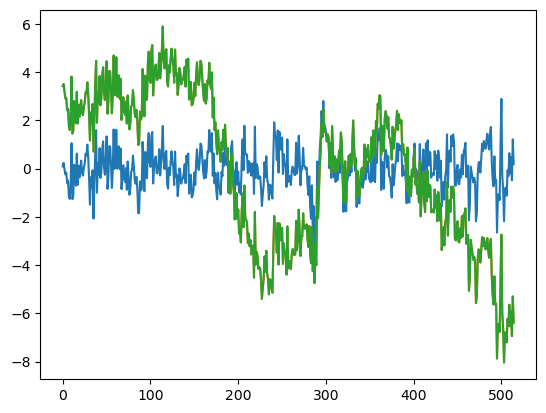

In [16]:
# import matplotlib.pyplot as plt
# import glob
# import pandas as pd
# t_r = 2
# roi_example = 'sn-l'
# atlas_type='useful'
# signal_fns = sorted(glob.glob(f'../derivatives/extracted_signals/*/sub-*/func/*task-*{atlas_type}-signals.tsv'))
# signal_load = pd.read_csv(signal_fns[0], sep='\t',index_col=0)#.set_index('volume')
# # signal_load = signal_load.apply(lambda x: (x/x.mean()*100)-100, axis=0)       # to PSC
# tmp = signal_load[roi_example].values #.apply(lambda x: (x/x.mean()*100)-100)
# signal_load_psc = signal_load.apply(lambda x: (x/x.mean()*100)-100, axis=0)     # to PSC
# signal_load_hp = signal_load_psc.apply(lambda x: butter_highpass_filter(x, cutoff=1/128, fs=1/t_r) + x.mean(), axis=0)  # SM: high-pass

# plt.plot(signal_load_hp[roi_example])
# plt.plot(signal_load_psc[roi_example])
# plt.plot((tmp/tmp.mean()*100)-100)

In [7]:
# load the signals
filter_out_confounds = False
overwrite = True
atlas_type = 'useful'
signal_fns = sorted(glob.glob(f'../derivatives/extracted_signals/*/sub-*/func/*task-*{atlas_type}-signals.tsv'))
signal_fns = [x for x in signal_fns if not '.bak' in x]
# signal_fns = [x for x in signal_fns if any(s in x for s in ['10','11','12','13','14','15'])]
# signal_fns = [x for x in signal_fns if 'aron_3T' not in x]
regex = re.compile(f'.*/(?P<dataset>(.*?))/sub-.*/func/sub-(?P<sub>[a-zA-Z0-9]+)_task-(?P<task>\S+)_run-(?P<run>\d)_desc-useful-signals.tsv')

# make mni brain a 4d image
#mni_brain = '/home/scotti/projects/3t_7t_sst_comparison/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'
#load_mni = nib.load(mni_brain)
# mni_data = load_mni.get_fdata()
mni_data = mni3mm.get_fdata()

def create_single_nii(signal_fn):
#for signal in signal_fns:
    gd = regex.match(signal_fn).groupdict()
    dataset, sub, task, run = gd['dataset'], gd['sub'], gd['task'], gd['run']
    print(dataset + ' ' + sub)
    
    if dataset == 'Leipzig_7T_SM':
        t_r = 3
    elif dataset == 'Leipzig_7T_GdH':
        t_r = 2
    elif dataset == 'openfmri_3T':
        t_r = 2
    elif dataset == 'aron_3T':
        t_r = 2
    elif dataset == 'NTNU_7T_SJSI':
        t_r = 1.38
    
    signal_load = pd.read_csv(signal_fn, sep='\t',index_col=0)#.set_index('volume')
    signal_load = signal_load.apply(lambda x: (x/x.mean()*100), axis=0)     # SM: to PSC, but keep 100 as baseline
    signal_load = signal_load.apply(lambda x: butter_highpass_filter(x, cutoff=1/128, fs=1/t_r) + x.mean(), axis=0)  # SM: high-pass

    
#     signal_load.rename(columns = {'lM1':'m1-l', 'rM1':'m1-r', 'gpel':'gpe-l','gper':'gpe-r','gpil':'gpi-l','gpir':'gpi-r',
#                  'rnl':'rn-l','rnr':'rn-r','snl':'sn-l','snr':'sn-r','stnl':'stn-l','stnr':'stn-r',
#                  'strl':'str-l','strr':'str-r','thal':'tha-l','thar':'tha-r','vtal':'vta-l','vtar':'vta-r','rPreSMA':'preSMA-r','lPreSMA':'preSMA-l'}, inplace = True)
    signal_load.rename(columns = {'M1-l':'m1-l', 'M1-r':'m1-r'}, inplace=True)
    signal_load = signal_load[rois_]
    
#     # filter out confounds?
#     if filter_out_confounds:
#         print('filtering confounds..')
#         _, confounds = load_events_confounds(sub=sub, dataset=dataset, task=task, run=run)
#         confounds['intercept'] = 1   # add intercept!
#         betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)
#         signals_hat = confounds@betas
#         signals_hat.index = signal_load.index
#         signals_hat.columns = signal_load.columns
# #         signal_load -= signals_hat   # residuals
#         signal_load = signals_hat.copy()   # -residuals    

    # load epi
    this_epi = get_epi(sub,dataset,task,run) # just for saving
#     default_epi = get_default_epi(dataset) # return default epi 
#     load_epi = nib.load(default_epi)
#     epi_data = load_epi.get_fdata()
#     epi_data[:,:,:,:] = 0 # make all zeros
    epi_data = np.ones((mni_data.shape + (len(signal_load),))) * 0 # set background value to -200
    
    # save fn
    save_fn = this_epi.replace('/fmriprep/fmriprep','').replace('fmriprep/','fsl_feat_roi_func/').replace('space-T1w','space-MNI152NLin2009cAsym')
    
    # overwrite yes or no?
    if not overwrite and os.path.exists(save_fn):
        print(save_fn)
        print('already exists and not overwriting.. ')
        #continue
        return 0
    
    txt_fn = f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fsl_feat_roi_func/{dataset}/sub-{sub}/func/sub-{sub}_ROI_voxels.txt'
    print(save_fn)
    # load ROI masks
#     these_masks = get_roi_masks(sub, dataset, task)
    these_masks = get_mni_roi_masks_first20() #get_mni_roi_masks()
    
    voxel_txt = []
    # loop through masks
    for this_mask in these_masks:
        
        load_mask = nib.load(this_mask).get_fdata()
        this_roi = this_mask.split('_label-')[-1].split('.')[0] 
#        print(this_roi)

        if (num_voxels:=len(load_mask[load_mask>0.5])) == 0:
            print(f'region {this_roi} in sub {sub}, {dataset} has no voxels above 50% probability')

        voxel_txt.append(f'region {this_roi} has {num_voxels} above 50% probability') 
        
        epi_data[load_mask>0.5,:] = signal_load[this_roi].values
        # loop through volumes ... ? SM: scott looped through volumes but unclear to me why
        #values   for vol, signal_ in enumerate(signal_load[this_roi].values.tolist()):

        #             epi_data[:,:,:,vol][load_mask>0.5] = signal_
            
    new_data = nib.nifti1.Nifti1Image(epi_data, affine = mni3mm.affine)
    os.makedirs(os.path.dirname(save_fn),exist_ok=True)
    new_data.to_filename(save_fn)
    with open(txt_fn, 'w') as fp:
        for vox in voxel_txt:
            # write each item on a new line
            fp.write("%s\n" % vox)
            
## multiprocess
import multiprocessing as mp
with mp.Pool(5) as p:
    p.map(create_single_nii, signal_fns)

# from joblib import Parallel, delayed
# Parallel(n_jobs=5)(delayed(create_single_nii)(fn) for fn in signal_fns)


# for signal_fn in signal_fns:
#     create_single_nii(signal_fn)

Leipzig_7T_GdH SC1TLeipzig_7T_GdH BI3TLeipzig_7T_GdH LV2TLeipzig_7T_SM 05Leipzig_7T_GdH WW2T




../derivatives/fsl_feat_roi_func/Leipzig_7T_SM/sub-05/func/sub-05_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
../derivatives/fsl_feat_roi_func/Leipzig_7T_GdH/sub-LV2T/func/sub-LV2T_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
../derivatives/fsl_feat_roi_func/Leipzig_7T_GdH/sub-SC1T/func/sub-SC1T_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
../derivatives/fsl_feat_roi_func/Leipzig_7T_GdH/sub-WW2T/func/sub-WW2T_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
../derivatives/fsl_feat_roi_func/Leipzig_7T_GdH/sub-BI3T/func/sub-BI3T_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Leipzig_7T_SM 05
../derivatives/fsl_feat_roi_func/Leipzig_7T_SM/sub-05/func/sub-05_task-stop_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Leipzig_7T_GdH LV2T
../derivatives/fsl_feat_roi_func/Leipzig_7T_GdH/

In [8]:
print('done')

done
